### List of Imports

In [1]:
import os
import gc
import time
import subprocess
import warnings
import requests
import colorsys
import pandas as pd
import numpy as np
import pandas as pd
from Bio.PDB import Selection, NeighborSearch
from collections import defaultdict
from Bio.PDB import PDBParser
import dask.dataframe as dd
import matplotlib.pyplot as plt
import plotly.express as px

# Paths definition

In [61]:
'''
General File structure should be something like:
https://tree.nathanfriend.io/?s=(%27opGHs!(%27fancy8~fullPath!fJse~trailingSlash8~rootDot8)~K(%27K%27work_dir5C0QD64Swissprot.DB4OthA_files_for_Mlookup_in_d6.DB--IntAmediates4F_protein_mulGple_seq2.Ji4summary_staGsGcs29quJity2_df93-Results4*Mdf9*MplotsL*4*additHJ4*5Pymol_output-Example4screenshotL35PDBsQ4D6_parsA_s7%204NeighbFhood_clustAA.py43-3-%27)~vAsiH!%271%27)*%20%20-5*0HsAvaGH2_Jignment3...%2F4-*5%5Cn*6atabase7cripts8!true9.csv4AerFourGtiHonJalKsFce!L.png4Mc0_Q-S7-%01QMLKJHGFA987654320-*
.
└── work_dir/
    ├── Conservation/
    │   ├── Scripts
    │   ├── Database/
    │   │   ├── Swissprot.DB
    │   │   └── Other_files_for_conservation_lookup_in_database.DB
    │   ├── Intermediates/
    │   │   ├── our_protein_multiple_seq_alignment.ali
    │   │   ├── summary_statistics_alignment.csv
    │   │   ├── quality_alignment_df.csv
    │   │   └── .../
    │   └── Results/
    │       ├── conservation_df.csv
    │       ├── conservation_plots.png
    │       └── additonal
    ├── Pymol_output/
    │   └── Example/
    │       ├── screenshot.png
    │       └── .../
    └── PDBs/
        ├── Scripts/
        │   ├── Database_parser_scripts 
        │   ├── Neighbourhood_clusterer.py
        │   └── .../
        └── .../

'''

# User dependent paths (must be passed as arguments)
work_dir= "/Users/fede/Desktop/Lab/Git/project_orellana_lab/mutational_clustering_work"
out_dir= "/Users/fede/Desktop/Lab/Projects/mutational_clustering"
cosmic_genome_screens_mutant_tsv="/Users/fede/Heavyfiles/Cosmic_GenomeScreensMutant_Tsv_v99_GRCh37/Cosmic_GenomeScreensMutant_v99_GRCh37.tsv"
clinvar_variant_summary_txt="/Users/fede/Heavyfiles/clinvar_variant_summary.txt"
pymol_executable= '/opt/homebrew/Caskroom/miniforge/base/envs/env_mutclust/bin/pymol'
egfr_pdb= "/Users/fede/Desktop/Lab/Projects/EGFR/data/models_Arkhipov/EGFR_monomer_nomem.pdb"
lox5_pdb= "/Users/fede/Desktop/Lab/Projects/Leuko/Data/5-LOX/model/5lox_model.pdb"
clp_pdb= "/Users/fede/Desktop/Lab/Projects/Leuko/Data/CLP/1vfq.pdb"

# User independent paths (repo files)
cosmic_classification= f"{work_dir}/Cosmic_Classification_v99_GRCh37.tsv"
cosmic_transcripts= f"{work_dir}/Cosmic_Transcripts_v99_GRCh37.tsv"

# Other paths
test_pdb=f"{work_dir}/1yoh.pdb"


# Pre-processing Class

Retrieves mutations from databases

Cosmic filters based on:
- Gene name
- Canonical transcript only
- Missense mutations only
- Known mutation significance 

Initialized with either:
- gene_name
- uniprot_id

> To do:
>  - Generalize from cosmic output to one raw all-databases output

In [48]:
class PreProcesser:
    def __init__(self, work_dir=None, out_dir=None, 
                 cosmic_genome_screens_mutant_tsv=None,
                 cosmic_classification=None,
                 cosmic_transcripts= None,
                 clinvar_variant_summary_txt=None, 
                 uniprot_id= None,
                 gene_name= None,
                 logging=True):
        
        self.work_dir = work_dir #the directory we want to work in
        self.log_dir = logging # we want to store log results for whatever we do.
        self.out_dir= out_dir
        self.cosmic_classification = cosmic_classification
        self.cosmic_transcripts= cosmic_transcripts
        self.cosmic_genome_screens_mutant_tsv= cosmic_genome_screens_mutant_tsv
        self.clinvar_variant_summary_txt= clinvar_variant_summary_txt
        self.uniprot_id= uniprot_id
        self.gene_name= gene_name
        self.cosmic_raw= None
        self.cosmic_processed= None
        self.cosmic_tissue_position= None
        self.cosmic_tissue_grouped= None

        # convert to gene name if uniprot_id
        self.genename_or_uniprotid()
        
    def genename_or_uniprotid(self):
        """
        if uniprot_id is provided to the class, this is always converted 
        to gene name
        """
        if self.gene_name is not None:
            pass
        elif self.uniprot_id is not None:
            self.gene_name = self._get_gene_name(self.uniprot_id)
        else:
            raise ValueError("Either uniprot_id or gene_name must be provided")

    def _get_gene_name(self, uniprot_id:str):
        """
        returns gene name from uniprot id
        """
    
        fields = "gene_primary"
        
        URL = f"https://rest.uniprot.org/uniprotkb/search?format=tsv&fields={fields}&query={uniprot_id}"
        resp = self._get_url(URL)
        resp = resp.text
        resp = resp.split("\n")

        if not resp[1]:
            raise ValueError("No gene name found for this Uniprot ID")

        if resp[2]:
            #ambigous result
            warnings.warn("Gene name search resulted in more than one hit:\n" + str(resp[1:]))
            
        return resp[1]

    def _visualize_clusters_pymol(self, pdb:str) -> None:
        """
        Utility function to visualize cluster in pymol.
        """
        
        #from pymol import cmd
        pass

    def _plot_clusters(self, pdb:str) -> object:
        """
        Helper function to plot some statistics or quick interactive plots to investigate clustering.
        Mostly thought about pyplot or plotly interactive plots i.e alignment where we can see the conservation etc.
        https://plotly.com/python/alignment-chart/
        """

    def compute_neighbours(self, pdb:str, cutoff=8.0) -> pd.DataFrame:

        parser= PDBParser()
        # Initialize parser and retrieve structure
        structure = parser.get_structure("default", pdb)
        atom_list = Selection.unfold_entities(structure, "A")  # Retrieve all atoms
    
        # Initialize NeighborSearch with all atoms and prepare to store results
        ns = NeighborSearch(atom_list)
        neighbour_dict = defaultdict(set)  # Use set to avoid duplicates
    
        # Define list of standard amino acids to exclude solvents and ligands
        aa_lst = [
            "VAL", "ALA", "GLY", "TRP", "ARG", "LYS", "LEU", "ILE", "ASP", "ASN",
            "GLN", "GLU", "PRO", "TYR", "PHE", "SER", "THR", "CYS", "MET", "HIS"
        ]
    
        # Search for neighboring residues for each atom
        for atom in atom_list:
            residue = atom.get_parent()
            res_name = residue.get_resname()
            res_id = residue.get_id()[1]
    
            # Skip non-amino acid residues
            if res_name not in aa_lst:
                continue
    
            # Search for neighboring residues within the cutoff distance
            for neighbour in ns.search(atom.get_coord(), cutoff, "R"):
                neighbour_id = neighbour.get_id()[1]
                if neighbour_id != res_id:  # Exclude the residue itself
                    neighbour_dict[res_name + str(res_id)].add(neighbour_id)
    
            
        # Convert the neighbor dictionary to a list of tuples
        neighbour_data = [(res_id, ' '.join(map(str, sorted(neighbours)))) for res_id, neighbours in neighbour_dict.items()]

        # Create a pandas DataFrame
        df_neighbours = pd.DataFrame(neighbour_data, columns=['Residue_ID', 'Neighbours'])
        return df_neighbours
    

    def conservation(self, uniprot_id):
        '''Gets 3 different types of Conservation:
        - Shannon conservation: 
        Shannon entropy. 
        Higher values indicate lower conservation and greater variability at the site.
        
        - Relative conservation:
        Kullback-Leibler divergence.
        Higher values indicate greater conservation and lower variability at the site.
        
        - Lockless conservation
        Evolutionary conservation parameter defined by Lockless and Ranganathan (1999). 
        Higher values indicate greater conservation and lower variability at the site.
        '''

        if self.log_dir and not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        
        mmseq_fasta_result = self._mmseq_multi_fasta(uniprot_id=uniprot_id, outdir=self.work_dir)
        #get 3 different conservation scores in a pandas df.
        conserv_df = self._get_conservation(path_to_msa=mmseq_fasta_result)
        self.conservation_df = conserv_df

        conserv_df.to_csv(f"{self.log_dir}/conservation_df.csv")

        
    def _mmseq_multi_fasta(self, uniprot_id:str, outdir:str, 
                      sensitivity=7, filter_msa=0,
                     query_id = 0.6):
        """
        uniprot_id: The unique uniprot identifier used to fetch the corresponding fasta file that will be used as a template for mmseq2
        outdir: location where result files will be stored.
        sensitivity: mmseq2 specific parameter that goes from 1-7. The higher the more sensitive the search.
        filter_msa = 0 default. if 1 hits are stricter.
        query_id = 0.6 [0, 1]  the higher the more identity with query is retrieved. 1 means ONLY the query hits while 0 means take everything possible.
        """

        #we blast with this fasta as query.
        trgt_fasta_seq = self._get_gene_fasta(uniprot_id)
        #Make outdir for all required files.
        #we need to write it out to file.
        with open(f"{self.work_dir}/{uniprot_id}_fasta.fa", "w") as fasta_out:
            fasta_out.write(f">{uniprot_id}\n")
            fasta_out.write(trgt_fasta_seq)

        #fetch pre downloaded database from a parent folder.
        msa_file = None
        new_location = None
        try:
            DB_storage_location = f"{work_dir}"
            #shutil.copy(previous_path, savepath)
            bash_curl_cmd = f"mmseqs createdb {self.work_dir}/{uniprot_id}_fasta.fa {DB_storage_location}/query_fastaDB" 
            bash_curl_cmd_rdy = bash_curl_cmd.split()
            #run first cmd which setups query database based on our input fasta file
            result_setup_query_db = run(bash_curl_cmd_rdy, stdout=PIPE, stderr=PIPE, 
                                 universal_newlines=True)
            bash_curl_cmd_2 = f"mmseqs search {DB_storage_location}/query_fastaDB {DB_storage_location}/swiss_DB {DB_storage_location}/result_DB {DB_storage_location}/tmp -s {sensitivity}"    
            bash_curl_cmd_rdy_2 = bash_curl_cmd_2.split()
            #run 2nd cmd which blasts against swiss_DB and generates the resultDB (i.e our hits that were found)
            result_setup_blast_db = run(bash_curl_cmd_rdy_2, stdout=PIPE, stderr=PIPE, 
                                 universal_newlines=True)
            #mmseqs convert2fasta DB_clu_rep DB_clu_rep.fasta
            bash_curl_cmd_5 = f"mmseqs result2msa {DB_storage_location}/query_fastaDB {DB_storage_location}/swiss_DB {DB_storage_location}/result_DB {DB_storage_location}/{uniprot_id}_out.fasta --msa-format-mode 3 --filter-msa {filter_msa} --qid {query_id}" 
            bash_curl_cmd_5_rdy = bash_curl_cmd_5.split()
            result_setup_msa_convert = run(bash_curl_cmd_5_rdy, stdout=PIPE, stderr=PIPE, 
                                 universal_newlines=True)
            #delete last line.. required.
            sed_cmd = f'sed -e 1,4d -e $d {DB_storage_location}/{uniprot_id}_out.fasta'        
            bash_curl_cmd_6_rdy = sed_cmd.split()
            #f"{DB_storage_location}/{uniprot_id}_new_out.fasta"
            with open(f"{DB_storage_location}/{uniprot_id}_new_out.fasta", "w") as new_fasta:
                result_truncation = run(bash_curl_cmd_6_rdy, stdout=new_fasta, stderr=PIPE, 
                                 universal_newlines=True)
            # Specify the path to your MSA file
            msa_file = f"{DB_storage_location}/{uniprot_id}_new_out.fasta"
            #transfer the meta file to another location and delete useless files.
            # we need to delete : all uniprot* files. 
            # all query*. All result* 
            new_location = f"{self.work_dir}/{uniprot_id}.fasta"
            shutil.copy(msa_file, new_location)
            #remove_files_and_dirs_msa(DB_storage_location, uniprot_id=uniprot_id)
            
        except Exception as error:
            print(error)
        #we want the path to msa_file for downstream analysis.
        return new_location

    def _get_gene_fasta(self, uniprot_id:str):
        '''
        Helper function to grab the sequence 
        based on the Uniprot ID
        '''
        fields = "sequence"
        URL = f"https://rest.uniprot.org/uniprotkb/search?format=fasta&fields={fields}&query={uniprot_id}"
        resp = self._get_url(URL)
        resp = resp.iter_lines(decode_unicode=True)
        seq = ""
        i = 0
        for lines in resp:
            if i > 0:
                seq += lines
            i += 1
        return seq

    def _get_conservation(self, path_to_msa:str):    
        '''
        Helper function to compute 3 different types of conservation.
        
        - Shannon conservation: 
        Shannon entropy. 
        Higher values indicate lower conservation and greater variability at the site.
        
        - Relative conservation:
        Kullback-Leibler divergence.
        Higher values indicate greater conservation and lower variability at the site.
        
        - Lockless conservation
        Evolutionary conservation parameter defined by Lockless and Ranganathan (1999). 
        Higher values indicate greater conservation and lower variability at the site.
        '''
        canal = Canal(fastafile=path_to_msa, #Multiple sequence alignment (MSA) of homologous sequences
          ref=0, #Position of reference sequence in MSA, use first sequence always
          startcount=0, # ALways 0 because our seqs are always from 1 - end
          verbose=False) # no verbosity 
    
        result_cons = canal.analysis(method="all")
        return result_cons

    def _get_url(self, url):
        '''Helper function that uses requests for Downloads.'''
        try:
            response = requests.get(url)  
            if not response.ok:
                print(response.text)
        except:
            response.raise_for_status()
            #sys.exit() 
        return response

    def _get_cosmic_mutations(self, **kwargs)->pd.DataFrame:
        """
        retrieves mutations from cosmic database from gene name (or uniprot id from higher level)
        """
        print ("Fetching Cosmic mutations..")
        start_time= time.time()
        path=self.cosmic_genome_screens_mutant_tsv             

        #default columns we want to retrieve. can be changed / added through kwargs later
        usecols=['GENE_SYMBOL', 'TRANSCRIPT_ACCESSION',
         'MUTATION_AA', 'MUTATION_DESCRIPTION', 'CHROMOSOME', 
                 'GENOME_START', 'GENOME_STOP', 'COSMIC_PHENOTYPE_ID', 'MUTATION_SOMATIC_STATUS', 'GENOMIC_MUTATION_ID', 'MUTATION_ID']

        df = dd.read_csv(path, sep="\t", dtype={'CHROMOSOME': 'object', 
        'GENOME_START': 'float64',
       'GENOME_STOP': 'float64'}, usecols=usecols)  #specify dtype / usecols to minimize memory usage required through load in.


        #we need to switch these tuples and then map the 1letter aa code to 3letter aa 
        #for later compatibility.
        lst =  [('Val',"V"), ('Ile',"I"), ('Leu',"L"), ('Glu',"E"), ('Gln',"Q"),
                    ('Asp',"D"), ('Asn',"N"), ('His',"H"), ('Trp',"W"), ('Phe',"F"), ('Tyr',"Y"), 
                    ('Arg',"R"), ('Lys',"K"), ('Ser',"S"), ('Thr',"T"), ('Met',"M"), ('Ala',"A"), 
                    ('Gly',"G"), ('Pro',"P"), ('Cys',"C")]
        
        lst = [(y, x) for x, y in lst] #switch y and x position for convinience

        canonical_aas = defaultdict(lambda: "X", lst) #default if key not found = "X"

        #filtering based on "missense" mutation. this can be tricky and sometimes messy but lets stick with that
        df_re = df[df["MUTATION_DESCRIPTION"].str.contains("missense")]

        #filter for gene name
        df_re = df_re[df_re["GENE_SYMBOL"] == f"{self.gene_name}"]
        
        #retrieve relevant information
        meta = ('Gene name', 'str') 
        df_re['CHROMOSOME'] = df_re['CHROMOSOME'].astype('object')
        df_re['WT_AA'] = df_re['MUTATION_AA'].str[2].apply(lambda x: canonical_aas[x], meta=meta)
        df_re['MUTATION_POSITION'] = df_re['MUTATION_AA'].str[3:-1]
        df_re['MUTATED_AA'] = df_re['MUTATION_AA'].str[-1].apply(lambda x: canonical_aas[x], meta=meta)

        #redundant so we drop it
        df_re = df_re.drop("MUTATION_AA", axis=1)

        #now we use compute() which finally does the computation (before all actions were "lazy" computations
        # so we dont actually need the RAM. now we do it though.)
        cosmic_df = df_re.compute()
    
        cosmic_df["GENOME_START"] = cosmic_df["GENOME_START"].astype(int)
        cosmic_df["GENOME_STOP"] = cosmic_df["GENOME_STOP"].astype(int)

        #Filter for canonical only transcripts
        transcripts_df= pd.read_csv(self.cosmic_transcripts, sep="\t")
        cosmic_df= pd.merge(cosmic_df, transcripts_df[['TRANSCRIPT_ACCESSION', 'IS_CANONICAL']], on='TRANSCRIPT_ACCESSION', how='left')
        cosmic_df= cosmic_df[cosmic_df["IS_CANONICAL"] == "y"]
        cosmic_df= cosmic_df.drop("IS_CANONICAL", axis=1)

        #Primary site is not directly retrievable
        #Fetch primary site from classification file based on cosmic_phenotype_id and merge
        columns_to_merge = ['COSMIC_PHENOTYPE_ID', 'PRIMARY_SITE', 'SITE_SUBTYPE_1', 'PRIMARY_HISTOLOGY', 'HISTOLOGY_SUBTYPE_1', 'HISTOLOGY_SUBTYPE_2']
        classification_df = pd.read_csv(self.cosmic_classification, sep='\t')
        cosmic_df = pd.merge(cosmic_df, classification_df[columns_to_merge], on='COSMIC_PHENOTYPE_ID', how='left')

        #Drop when ambigous position (more than one position reported, very rare) 
        cosmic_df['MUTATION_POSITION'] = pd.to_numeric(cosmic_df['MUTATION_POSITION'], errors='coerce')
        cosmic_df = cosmic_df.dropna(subset=['MUTATION_POSITION'])

        #Drop when MUTATION_SOMATIC_STATUS = Variant of unknown origin (lack of normal tissue control) 
        cosmic_df = cosmic_df.drop(cosmic_df[cosmic_df['MUTATION_SOMATIC_STATUS'] == 'Variant of unknown origin'].index)
        
        #Sorting rules
        cosmic_df['MUTATION_POSITION'] = cosmic_df['MUTATION_POSITION'].astype(int)
        cosmic_df = cosmic_df.sort_values(['MUTATION_POSITION', 'MUTATED_AA', 'GENOMIC_MUTATION_ID'], ascending=True)

    
        end_time= time.time()
        exec_time= end_time - start_time
        print (f"{len(cosmic_df)} mutations found")
        print (f"Execution time: {exec_time:.2f} seconds")
    
        return cosmic_df

    def _get_gnomad_mutations(self, gnomad_data_table_path:str, **kwargs)-> pd.DataFrame:
        """Documentation.
        Currently this part does not convert the result to a df.
        I will implement it and return a pandas DF

        Please Fede let me do this. I really want to do this, don't touch it.
        I got this I can't wait.
        I'm the Gnomad master! Yay!
        """
        mt = hl.read_matrix_table(path)  #matrix table because df would not work with such large data.


        #string based search because there is NO API for gnomAD.
        substring1 = self.gene_name
        substring2 = "missense"
        
        mt = mt.annotate_rows(Gene_names=mt.info.vep.map(
            lambda x: x.split("\|")[3]) ,
                          type_of_change = mt.info.vep.map(
            lambda x: x.split("\|")[1]) , 
                          AA_change = mt.info.vep.map(
            lambda x: x.split("\|")[11]) , 
                          ENST_identifier= mt.info.vep.map(
            lambda x: x.split("\|")[6])
    
        ) 
                 
        filtered_mt_2 = mt.filter_rows(
        #hl.any(lambda x: hl.str(x).contains(substring3), mt.AA_change)
        hl.any(lambda x: hl.str(x).contains(substring1), mt.info.vep) &
        hl.any(lambda x: hl.str(x).contains(substring2), mt.info.vep)
        
        )
                         
        filtered_mt_3 = filtered_mt_2.annotate_rows(
            Allele_count_int = filtered_mt_2.info.AC,
            Allele_frequency_float = filtered_mt_2.info.AF,
            Allele_number_int = filtered_mt_2.info.AN,
            Gene_name_str = _replace_empty(filtered_mt_2.Gene_names), 
            Mutation_change_str = _replace_empty(filtered_mt_2.AA_change),
            Type_of_change_str = _replace_empty(filtered_mt_2.type_of_change))
        
        #this can be again regulated later trough kwargs**
        rows_to_keep = ["Gene_name_str", "Mutation_change_str", "Type_of_change_str", "Allele_count_int",
                    "Allele_frequency_float", "Allele_number_int"]
    
    
        selected_rows = filtered_mt_3.select_rows(
            Allele_count_int=filtered_mt_3.Allele_count_int,
            Allele_frequency_float=filtered_mt_3.Allele_frequency_float,
            Allele_number_int=filtered_mt_3.Allele_number_int,
            Gene_name_str=hl.str(filtered_mt_3.Gene_name_str),
            Mutation_change_str=hl.str(filtered_mt_3.Mutation_change_str),
            Type_of_change_str=hl.str(filtered_mt_3.Type_of_change_str)
                )
    
        save_buffer = selected_rows.select_rows(*rows_to_keep)
        select_rows_out = save_buffer.rows()

        return (select_rows_out)
        #part missing to convert to pandas DF.
        
        #return pd.DataFrame() 

    def _get_clinvar_mutations(self, **kwargs)-> pd.DataFrame:
        """
        Documentation missing.
        """
        
        #can be regulated through kwargs
        use_cols = ["Type", "Name", "GeneSymbol",
           "ClinicalSignificance", "PhenotypeList",
           "Assembly", "ChromosomeAccession", 
           "Chromosome", "Start", "Stop"]
        
        #this here as well / mapping needed to save memory at load in.
        column_data_types = {
        "Type": str,
        "Name": str,
        "GeneSymbol": str,
        "ClinicalSignificance": str,
        "PhenotypeList": str,
        "Assembly": str,
        "ChromosomeAccession": str,
        "Chromosome": str,
        "Start": int,
        "Stop": int
        }

        #lets read in the clinvar all var file.
        df_work = pd.read_csv(self.clinvar_variant_summary_txt, sep="\t", usecols=use_cols, dtype=column_data_types)
    
        df_work.loc[:, "AA_change"] = df_work["Name"].str.split().str.get(-1)
        df_work.loc[:, "AA_change"] = df_work["AA_change"].str.replace("(", "")
        df_work.loc[:, "AA_change"] = df_work["AA_change"].str.replace(")", "")
        
        df_work.loc[:,"Original_AA"] = df_work["AA_change"].str[2:5]
        df_work.loc[:,"Modified_AA"] = df_work["AA_change"].str[-3:]
        df_work['Position'] = pd.to_numeric(df_work['AA_change'].str[5:-3], errors='coerce')
        
        # Drop rows with NaN values in the 'Position' column
        df_work.dropna(subset=['Position'], inplace=True)
        df_work['Position'] = df_work['Position'].astype(int)
        
        df_work["Genomic_location"] = df_work["Chromosome"] + ":" + df_work["Start"].astype(str)
        df_work["gnomad_aa_change"] = "p." + df_work["Original_AA"] + df_work["Position"].astype(str) + df_work["Modified_AA"]
        
        df_work = df_work.drop("AA_change", axis=1)
        df_work = df_work.drop("Name", axis=1)
        df_work = df_work.drop("Chromosome", axis=1)
        df_work = df_work.drop("Start", axis=1)
        df_work = df_work.drop("Stop", axis=1)
        
        
        accepted_residues = ["Ala", "Gly", "Ser", "Leu", "Pro",
                        "Ile", "Val", "Phe", "Tyr", "Trp",
                         "His", "Thr", "Asn", "Gln", "Asp", 
                         "Glu","Cys", "Met", "Lys", "Arg"]
        
        #filtering based on our Gene name.
        df_clinvar = df_work[(df_work["Type"] == "single nucleotide variant") & 
            (df_work["GeneSymbol"] == self.gene_name) &
            (df_work["Assembly"] == "GRCh37") & 
            (df_work['Original_AA'].isin(accepted_residues)) &
            (df_work['Modified_AA'].isin(accepted_residues)) ]
        
        #export

        df_clinvar=df_clinvar.sort_values('Position', ascending=True)
        
        return df_clinvar

    def fetch_mutations(self, **kwargs):
        print (f"Fetching mutations for gene name: {self.gene_name}")
        #cosmic
        if 'cosmic' in kwargs and kwargs['cosmic']:
            cosmic_df=self._get_cosmic_mutations()
            self.cosmic_raw=cosmic_df
          
        #clinvar
        if 'clinvar' in kwargs and kwargs['clinvar']:
            clinvar_df=self._get_clinvar_mutations()
            self.clinvar_df=clinvar_df

#pre_processer = PreProcesser(work_dir=work_dir, out_dir=out_dir,
#                                cosmic_classification=cosmic_classification, 
#                                cosmic_genome_screens_mutant_tsv=cosmic_genome_screens_mutant_tsv,
#                                clinvar_variant_summary_txt=clinvar_variant_summary_txt,
#                                uniprot_id="P09917"
#                               )

#EXAMPLE USAGE
#pre_processer.compute_neighbours(test_pdb)
#pre_processer.fetch_mutations(cosmic=True)
#pre_processer.cosmic_raw.head()

# Processing Class
Takes ONE input raw dataframe (one for all dataframes)

TO DO: implement a check that excludes non-canonical residues for each positions

In [88]:
class Processer:
    """               LOGIC
    
    Processor
    └── pre_processer.cosmic_raw (preliminary processing, currently only cosmic)
        └── self.raw_df
            └── processed_df
                └── self.tissue_position_df
                    ├── self.tissue_grouped_df
                    └── self.tissue_aspecific_df
    """

    def __init__(self, raw_df: pd.DataFrame):
        self.raw_df=raw_df
        self.tissue_position_df= None
        self.tissue_grouped_df= None
        self.tissue_aspecific_df= None

    def _filter_by_mutation(self, WT_AA, MUTATION_POSITION, MUTATED_AA, df):
        filtered_df= df[(df["WT_AA"] == WT_AA) & 
                              (df["MUTATION_POSITION"] == MUTATION_POSITION) & 
                              (df["MUTATED_AA"] == MUTATED_AA)]
    
        print ("Filtered for "+WT_AA+"_"+str(MUTATION_POSITION)+"_"+MUTATED_AA+"\nResulting mutation count:", len (filtered_df))
        return filtered_df

    def _filter_by_histology(self, histology, df):
        
        filtered_df= df[(df["PRIMARY_HISTOLOGY"].str.contains(histology) | 
                         df["HISTOLOGY_SUBTYPE_1"].str.contains(histology) | 
                         df["HISTOLOGY_SUBTYPE_2"].str.contains(histology))]

        print (f"Filtered for histology/ primary histology/ secondary histology containing: {histology}"+"\nResulting mutation count:", len (filtered_df))
        return filtered_df
        
    def process_mutations(self, **kwargs):
        if self.raw_df is None or self.raw_df.empty:
            raise ValueError("self.raw_df was not computed or is empty. Please compute it before processing.")

        
        if "keep_pre_processed" not in kwargs:
            del pre_processer.cosmic_raw
            gc.collect()
        else:
            """Keeping pre processed raw dataframe available"""
            
       
        if 'filter_by_mutation' in kwargs:
            self.raw_df=self._filter_by_mutation(*kwargs["filter_by_mutation"], df=self.raw_df)

        if 'filter_by_histology' in kwargs:
            self.raw_df=self._filter_by_histology(*kwargs["filter_by_histology"], df=self.raw_df)
        
        # Drop MUTATION_SOMATIC_STATUS (we keep both confirmed and reported in another sample as somatic. Unknown was previously filtered out)
        processed_df=self.raw_df.drop(["MUTATION_SOMATIC_STATUS", 'COSMIC_PHENOTYPE_ID', 'SITE_SUBTYPE_1', 'PRIMARY_HISTOLOGY', 'HISTOLOGY_SUBTYPE_1', 'HISTOLOGY_SUBTYPE_2'], axis=1)
        # Collapse duplicate rows based on all columns (these are just different samples) 
        #duplicate_mask = processed_df.duplicated()
        processed_df = processed_df.groupby(processed_df.columns.tolist()).size().reset_index(name='SAMPLES')

        if 'keep_raw' not in kwargs:
            """save if you want to take a look at only filtered mutations but in raw format"""
            del self.raw_df
            gc.collect()
        else:
            print ("Keeping raw processed dataframe available")
        
        def tissue_position_processing(processed_df: pd.DataFrame) -> pd.DataFrame: 
            """
            TO DO
            this df can keep track of the wild-type amino acid and groupy it
            """
            
            # TISSUE SPECIFIC DF, POSITION PER POSITION
            selected_columns = ["MUTATION_ID", "MUTATION_POSITION", "PRIMARY_SITE", "SAMPLES"]
            tissue_position_df = processed_df[selected_columns]
            tissue_position_df = tissue_position_df.sort_values(["PRIMARY_SITE", 'MUTATION_POSITION', "MUTATION_ID"], ascending=True)
            # Group by mutation position and primary site, count how many unique MUTATION_IDs were collapsed, sum SAMPLES
            tissue_position_df = tissue_position_df.groupby(['MUTATION_POSITION', 'PRIMARY_SITE']).agg(
                {'MUTATION_ID': 'nunique', 'SAMPLES': 'sum'}).reset_index().rename(columns={'MUTATION_ID': 'COUNT_MUTATION_IDs', 'SAMPLES': 'SAMPLES_TOT'})
            ## Introduce samples per mutation
            tissue_position_df['SAMPLES_DIV_COUNT'] = tissue_position_df['SAMPLES_TOT'] / tissue_position_df['COUNT_MUTATION_IDs']
            tissue_position_df= tissue_position_df.sort_values(["PRIMARY_SITE", "MUTATION_POSITION"], ascending=True)
            #tissue_position_df = tissue_position_df.drop(columns=['SAMPLES_DIV_COUNT'])
            # PYMOL 3D CLUSTERING OUT HERE
            del processed_df
            gc.collect()
            return tissue_position_df

        def tissue_grouped_processing(tissue_position_df: pd.DataFrame) -> pd.DataFrame:
            #TISSUE SPECIFIC DF, GROUPED BY POSITION
            tissue_grouped_df = tissue_position_df.groupby('PRIMARY_SITE').agg(
                MUTATION_POSITIONS=('MUTATION_POSITION', 'nunique'),
                COUNT_MUTATION_IDs=('COUNT_MUTATION_IDs', 'sum'),
                SAMPLES_TOT=('SAMPLES_TOT', 'sum')
                ).reset_index()            
            tissue_grouped_df.rename(columns={'MUTATION_POSITION': 'MUTATION_POSITIONS'}, inplace=True)
            tissue_grouped_df["SAMPLES_DIV_COUNT"]= (tissue_grouped_df["SAMPLES_TOT"]/tissue_grouped_df["COUNT_MUTATION_IDs"]).round(2)
            
            return tissue_grouped_df

        def tissue_aspecific_processing(tissue_position_df: pd.DataFrame) -> pd.DataFrame:            
            #TISSUE ASPECIFIC DF
            tissue_aspecific_df= tissue_position_df.drop(['PRIMARY_SITE', 'SAMPLES_DIV_COUNT'], axis=1)
            tissue_aspecific_df = tissue_aspecific_df.groupby('MUTATION_POSITION').agg({
                'COUNT_MUTATION_IDs': 'sum',
                'SAMPLES_TOT': 'sum'
            }).reset_index()
            return tissue_aspecific_df

        
        if 'tissue_position' in kwargs:
            self.tissue_position_df=tissue_position_processing(processed_df= processed_df)
            
            print ("Created tissue position dataframe")
            
        if 'tissue_grouped' in kwargs:
            if self.tissue_position_df is None or self.tissue_position_df.empty:
                self.tissue_position_df= tissue_position_processing(processed_df= processed_df)
                
            self.tissue_grouped_df= tissue_grouped_processing(tissue_position_df= self.tissue_position_df)
            if 'tissue_position' not in kwargs: 
                del self.tissue_position_df
                gc.collect()

            print ("Created tissue grouped dataframe")
            
        if 'tissue_aspecific' in kwargs:
            if self.tissue_position_df is None or self.tissue_position_df.empty:
                self.tissue_position_df= tissue_position_processing(processed_df= processed_df)

            self.tissue_aspecific_df= tissue_aspecific_processing(tissue_position_df= self.tissue_position_df)
            if 'tissue_position' not in kwargs: 
                del self.tissue_position_df
                gc.collect()

            print ("Created tissue aspecific dataframe")

# 3D Visualizing Class

In [65]:
class Visualizer:
    def __init__(self, pdb: str, shift: int, pymol_executable: str, tissue_position_df=None, radius_divider: int=5):
        self.work_dir = work_dir
        self.out_dir= out_dir
        self.pdb= pdb
        self.shift= shift
        self.pymol_ex= pymol_executable
        self.tissue_position_df = tissue_position_df
        self.radius_divider= radius_divider
        
        pathname, extension = os.path.splitext(self.pdb)
        self.moleculename = pathname.split('/')[-1]
        self.tumor_heterogeneity_script = f'{out_dir}/tumor_heterogeneity_{self.moleculename}.py'
        self.tumor_frequency_script = f'{out_dir}/tumor_frequency_{self.moleculename}.py'
    
    def pymol_cluster_heterogeneity(self, export:bool= True):
        """
        Mutations are plotted by number of unique mutation IDs
        """
        if self.tissue_position_df is None or self.tissue_position_df.empty:
            raise ValueError ("tissue_position_df was not computed or is empty. Please compute it before visualizing")
    
        lines = []
        #automatize shift
        
        
        for _, row in self.tissue_position_df.iterrows():
            primary_site = row['PRIMARY_SITE']
            canonical_position = row['MUTATION_POSITION']
            structure_position = canonical_position + self.shift
            count_mutation_ids = row['COUNT_MUTATION_IDs']
            line = f'cmd.pseudoatom("{primary_site}", "{structure_position}/CA", vdw={count_mutation_ids/self.radius_divider}, label="{canonical_position} - {count_mutation_ids}")'
            lines.append(line)
        
        lines.append(f"""cmd.show ("spheres", "not {self.moleculename}")""")
        lines.append(f"""cmd.spectrum ("count", "rainbow", "not {self.moleculename}")""")
        lines.append(f"""cmd.spectrum ("count", "rainbow", "{self.moleculename}")""")
        lines.append("""cmd.remove ("resname HOH")""")
        #lines.append(f"""cmd.hide ("labels")""")
        #lines.append(f"""cmd.show_as ("surface", "{self.moleculename}")""")
        lines.append(f"""cmd.set ("transparency", "0.8", "{self.moleculename}")""")
        lines.append(f"""cmd.set ("cartoon_transparency", "0.8", "{self.moleculename}")""")
        lines.append(f"""movie.add_roll(32.0,axis='y',start=1)""")
        #lines.append(f"""cmd.set ("label_color", "rainbow", "not {self.moleculename}")""")
    
        # Write the lines to a text file
        if export:
            with open(self.tumor_heterogeneity_script, 'w') as file:
                for line in lines:
                    file.write(line + '\n')
            print(f"Lines exported to 'tumor_heterogeneity.py'.")

    def pymol_cluster_frequency(self, export:bool= True):
        if self.tissue_position_df is None or self.tissue_position_df.empty:
            raise ValueError ("tissue_position_df was not computed or is empty. Please compute it before visualizing")
    
        lines = []
        #automatize shift
        pathname, extension = os.path.splitext(self.pdb)
        self.moleculename = pathname.split('/')[-1]
        
        for _, row in self.tissue_position_df.iterrows():
            primary_site = row['PRIMARY_SITE']
            canonical_position = row['MUTATION_POSITION']
            structure_position = canonical_position + self.shift
            count_mutation_frequency = row['SAMPLES_TOT']
            line = f'cmd.pseudoatom("{primary_site}", "{structure_position}/CA", vdw={count_mutation_frequency/self.radius_divider}, label="{canonical_position} - {count_mutation_frequency}")'
            lines.append(line)
        
        lines.append(f"""cmd.show ("spheres", "not {self.moleculename}")""")
        lines.append(f"""cmd.spectrum ("count", "rainbow", "not {self.moleculename}")""")
        lines.append(f"""cmd.spectrum ("count", "rainbow", "{self.moleculename}")""")
        lines.append("""cmd.remove ("resname HOH")""")
        #lines.append(f"""cmd.hide ("labels")""")
        #lines.append(f"""cmd.show_as ("surface", "{self.moleculename}")""")
        lines.append(f"""cmd.set ("transparency", "0.8", "{self.moleculename}")""")
        lines.append(f"""cmd.set ("cartoon_transparency", "0.8", "{self.moleculename}")""")
        lines.append(f"""movie.add_roll(32.0,axis='y',start=1)""")
        #lines.append(f"""cmd.set ("label_color", "rainbow", "not {self.moleculename}")""")
    
        # Write the lines to a text file
        if export:
            with open(self.tumor_frequency_script, 'w') as file:
                for line in lines:
                    file.write(line + '\n')
            print(f"Lines exported to 'tumor_frequency.py'.")
        
    def pymol_launcher(self, pymol_script: str):    
        memory_opt= 'set defer_builds_mode, 3'
        py_command = [
                self.pymol_ex,
                '-d',
                f'{memory_opt}; load {self.pdb}',
                pymol_script
            ]
        print (" ".join(py_command))
        # Start pymol as a separate process and detach it from the Python script, then wait for it to complete
        process = subprocess.run(py_command, text=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, stdin=subprocess.PIPE, preexec_fn=os.setpgrp)

    def visualize(self, **kwargs):
        if "tumor_heterogeneity" in kwargs and kwargs['tumor_heterogeneity']:
            self.pymol_cluster_heterogeneity(export= True)
            self.pymol_launcher(pymol_script=self.tumor_heterogeneity_script)
        if "tumor_frequency" in kwargs and kwargs['tumor_frequency']:
            self.pymol_cluster_frequency(export= True)
            self.pymol_launcher(pymol_script=self.tumor_frequency_script)


# EGFR shift is 24

#visualizer=Visualizer(pdb=egfr_pdb, shift= 24, 
#                      pymol_executable= pymol_executable, 
#                      tissue_position_df=processer.tissue_position_df)

#visualizer=Visualizer(pdb=lox5_pdb, shift= 0, 
#                      pymol_executable= pymol_executable, 
#                      tissue_position_df=processer.tissue_position_df)

# Exporting Class

In [35]:
class Exporter:
    def __init__(self, out_dir, 
                 gene_name: str,
                 raw_df: pd.DataFrame= None,
                 processed_raw_df: pd.DataFrame= None,
                 tissue_position_df: pd.DataFrame= None,
                 tissue_grouped_df: pd.DataFrame= None,
                 tissue_aspecific_df: pd.DataFrame= None):

        self.gene_name= gene_name
        self.out_dir= out_dir   
        self.raw= raw_df
        self.processed_raw= processed_raw_df
        self.tissue_grouped= tissue_grouped_df
        self.tissue_position= tissue_position_df
        self.tissue_aspecific= tissue_aspecific_df
    
    def export(self, **kwargs):
        "valid: raw, processed_raw, tissue_grouped, tissue_position, tissue_aspecific"
        for key in kwargs:
            df= getattr(self, key)
            if df is not None:
                 df.to_csv(os.path.join(self.out_dir, f'df_{self.gene_name}_{key}.tsv'), sep='\t', index=False)
            else:
                 raise ValueError(f"self.{key} was not computed. Please compute it before exporting.")
                    

# Fede Testing

## EGFR

In [10]:
pre_processer = PreProcesser(work_dir=work_dir, out_dir=out_dir,
                                cosmic_classification=cosmic_classification,
                                cosmic_transcripts=cosmic_transcripts,
                                cosmic_genome_screens_mutant_tsv=cosmic_genome_screens_mutant_tsv,
                                clinvar_variant_summary_txt=clinvar_variant_summary_txt,
                                gene_name="EGFR"
                               )
print (pre_processer.gene_name)
pre_processer.fetch_mutations(cosmic=True)

EGFR
Fetching Cosmic mutations..
911 mutations found
Execution time: 64.45 seconds


In [41]:
processer= Processer(raw_df=pre_processer.cosmic_raw)
processer.process_mutations(tissue_position=True, tissue_grouped=True, tissue_aspecific= True, filter_by_histology=["astrocytoma"], raw=True)

Filtered for histology or primary istology containing: astrocytoma
Resulting mutation count: 212
Created tissue position dataframe
Created tissue grouped dataframe
Created tissue aspecific dataframe


In [91]:
#visualizer=Visualizer(pdb=egfr_pdb, shift= 24, 
#                      pymol_executable= pymol_executable, 
#                      tissue_position_df=processer.tissue_position_df,
#                      radius_divider= 50)
#visualizer.visualize(tumor_frequency=True)

In [39]:
exporter=Exporter(out_dir=out_dir,
                  gene_name= pre_processer.gene_name,
                  raw_df= pre_processer.cosmic_raw,
                  tissue_position_df= processer.tissue_position_df,
                 tissue_aspecific_df= processer.tissue_aspecific_df,
                 tissue_grouped_df= processer.tissue_grouped_df)
exporter.export(raw=True, tissue_position=True, tissue_grouped=True, tissue_aspecific=True)

## 5-LOX

In [9]:
pre_processer = PreProcesser(work_dir=work_dir, out_dir=out_dir,
                                cosmic_classification=cosmic_classification, 
                                cosmic_transcripts=cosmic_transcripts,
                                cosmic_genome_screens_mutant_tsv=cosmic_genome_screens_mutant_tsv,
                                clinvar_variant_summary_txt=clinvar_variant_summary_txt,
                                uniprot_id="P09917"
                               )

pre_processer.fetch_mutations(cosmic=True)

fetching mutations for gene name: ALOX5
Fetching Cosmic mutations..
334 mutations found
Execution time: 68.85 seconds


In [84]:
processer= Processer(raw_df=pre_processer.cosmic_raw)
processer.process_mutations(tissue_position=True, keep_raw=True, keep_pre_processed=False)

AttributeError: 'PreProcesser' object has no attribute 'cosmic_raw'

In [51]:
visualizer=Visualizer(pdb=lox5_pdb, shift= 0, 
                      pymol_executable= pymol_executable, 
                      tissue_position_df=processer.tissue_position_df,
                      radius_divider=5)

visualizer.visualize(tumor_frequency=True, tumor_heterogeneity=True)

Lines exported to 'tumor_heterogeneity.py'.
/opt/homebrew/Caskroom/miniforge/base/envs/env_mutclust/bin/pymol -d set defer_builds_mode, 3; load /Users/fede/Desktop/Lab/Projects/5-LOX/Data/model/5lox_model.pdb /Users/fede/Desktop/Lab/Projects/mutational_clustering/tumor_heterogeneity_5lox_model.py
Lines exported to 'tumor_frequency.py'.
/opt/homebrew/Caskroom/miniforge/base/envs/env_mutclust/bin/pymol -d set defer_builds_mode, 3; load /Users/fede/Desktop/Lab/Projects/5-LOX/Data/model/5lox_model.pdb /Users/fede/Desktop/Lab/Projects/mutational_clustering/tumor_frequency_5lox_model.py


In [43]:
exporter=Exporter(out_dir=out_dir,
                  gene_name= pre_processer.gene_name,
                  raw_df= pre_processer.cosmic_raw,
                  processed_raw_df=processer.raw_df, 
                 tissue_aspecific_df= processer.tissue_aspecific_df,
                 tissue_grouped_df= processer.tissue_grouped_df,
                tissue_position_df=processer.tissue_position_df)
exporter.export(raw=True, tissue_position=True, tissue_grouped=True, tissue_aspecific=True)

## CLP

In [52]:
pre_processer = PreProcesser(work_dir=work_dir, out_dir=out_dir,
                                cosmic_classification=cosmic_classification, 
                                cosmic_transcripts=cosmic_transcripts,
                                cosmic_genome_screens_mutant_tsv=cosmic_genome_screens_mutant_tsv,
                                clinvar_variant_summary_txt=clinvar_variant_summary_txt,
                                uniprot_id="Q14019"
                               )

pre_processer.fetch_mutations(cosmic=True)

Fetching mutations for gene name: COTL1
Fetching Cosmic mutations..
48 mutations found
Execution time: 64.42 seconds


In [58]:
processer= Processer(raw_df=pre_processer.cosmic_raw)
processer.process_mutations(tissue_position=True, tissue_grouped=True, tissue_aspecific=True)

Created tissue position dataframe
Created tissue grouped dataframe
Created tissue aspecific dataframe


In [59]:
exporter=Exporter(out_dir=out_dir,
                  gene_name= pre_processer.gene_name,
                  raw_df= pre_processer.cosmic_raw, 
                 tissue_aspecific_df= processer.tissue_aspecific_df,
                 tissue_grouped_df= processer.tissue_grouped_df,
                tissue_position_df=processer.tissue_position_df)
exporter.export(tissue_position=True, tissue_grouped=True, tissue_aspecific=True, raw=True)

In [69]:
visualizer=Visualizer(pdb=clp_pdb, shift=0, 
                      pymol_executable= pymol_executable, 
                      tissue_position_df=processer.tissue_position_df,
                      radius_divider=2)

visualizer.visualize(tumor_frequency=True, tumor_heterogeneity=True)

Lines exported to 'tumor_heterogeneity.py'.
/opt/homebrew/Caskroom/miniforge/base/envs/env_mutclust/bin/pymol -d set defer_builds_mode, 3; load /Users/fede/Desktop/Lab/Projects/Leuko/Data/CLP/1vfq.pdb /Users/fede/Desktop/Lab/Projects/mutational_clustering/tumor_heterogeneity_1vfq.py
Lines exported to 'tumor_frequency.py'.
/opt/homebrew/Caskroom/miniforge/base/envs/env_mutclust/bin/pymol -d set defer_builds_mode, 3; load /Users/fede/Desktop/Lab/Projects/Leuko/Data/CLP/1vfq.pdb /Users/fede/Desktop/Lab/Projects/mutational_clustering/tumor_frequency_1vfq.py


## FLAP

Uniprot ID= P20292

# Plotting Class

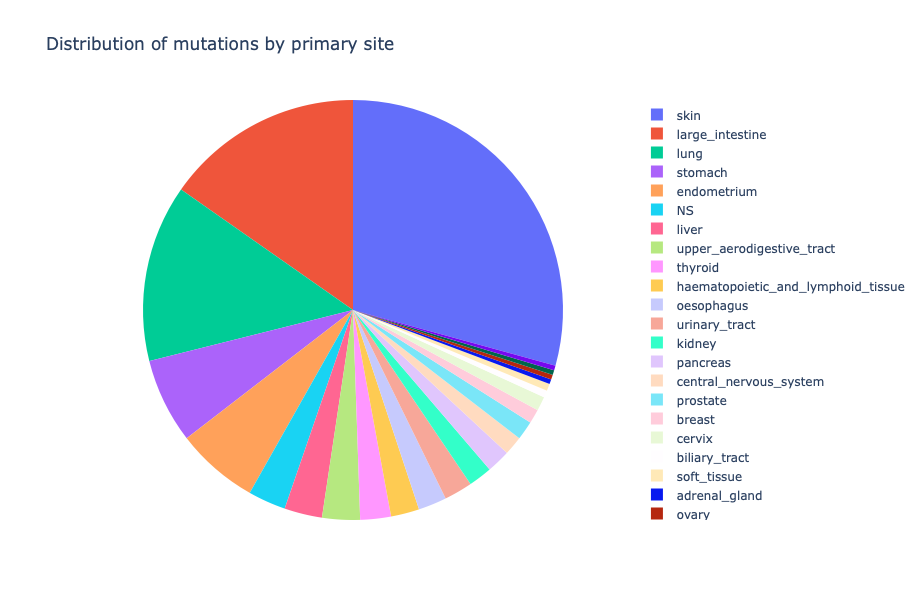

In [23]:
fig = px.pie(processer.tissue_grouped_df, values='COUNT_MUTATION_IDs', names='PRIMARY_SITE', title='Distribution of mutations by primary site')
#fig.update_traces(textinfo='value+percent')
fig.update_traces(textinfo='none')
fig.update_layout(width=800, height=600)
fig.show()

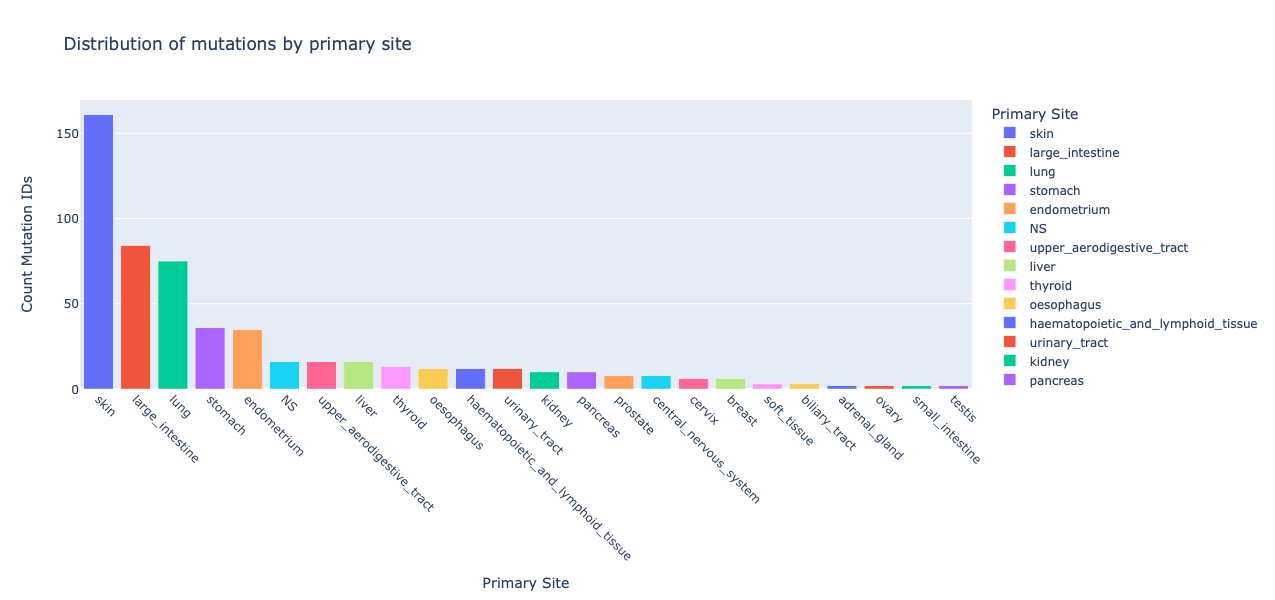

In [22]:
tissue_grouped_df_sorted = processer.tissue_grouped_df.sort_values(by='COUNT_MUTATION_IDs', ascending=False)

fig = px.bar(tissue_grouped_df_sorted, x='PRIMARY_SITE', y='COUNT_MUTATION_IDs', 
             title='Distribution of mutations by primary site', 
             labels={'COUNT_MUTATION_IDs': 'Count Mutation IDs', 'PRIMARY_SITE': 'Primary Site'},
             color="PRIMARY_SITE",
             width=1200, height=600)
fig.update_layout(xaxis={'tickangle': 45}, showlegend=True)
#transparent background
#fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')

fig.show()

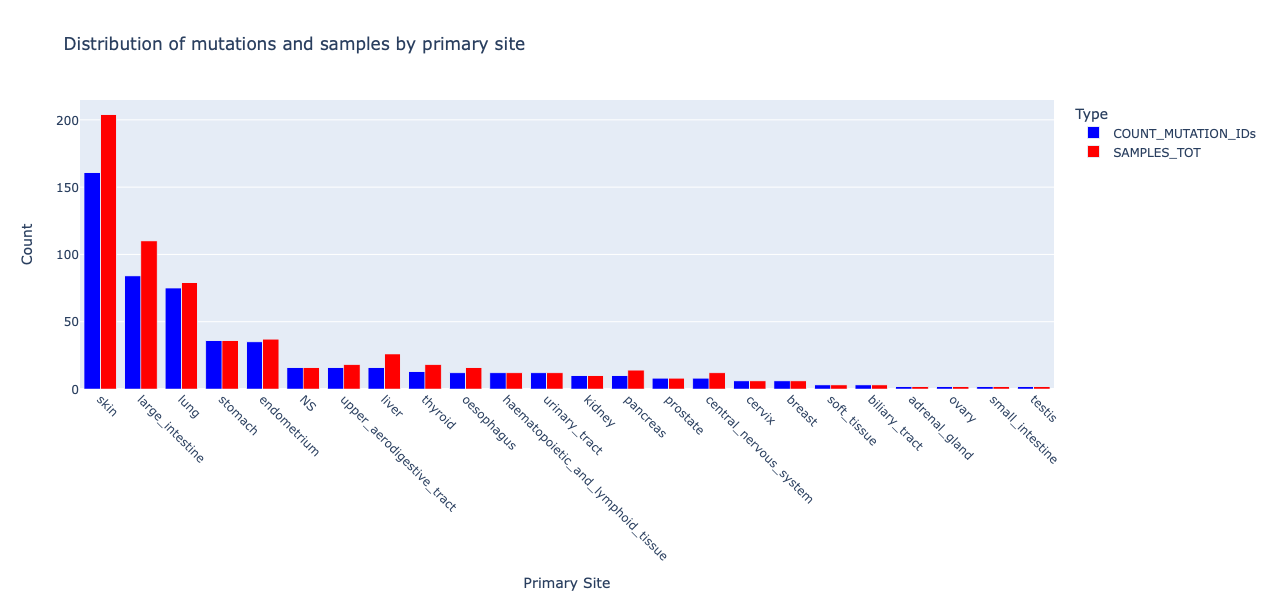

In [21]:

tissue_grouped_df_sorted = processer.tissue_grouped_df.sort_values(by='COUNT_MUTATION_IDs', ascending=False)

#fig = px.bar(tissue_grouped_df_sorted, x='PRIMARY_SITE', y='COUNT_MUTATION_IDs', 
#             title='Distribution of mutations by primary site', 
#             labels={'COUNT_MUTATION_IDs': 'Count Mutation IDs', 'PRIMARY_SITE': 'Primary Site'},
#             color="PRIMARY_SITE",
#             width=1200, height=600)

fig = px.bar(tissue_grouped_df_sorted, x='PRIMARY_SITE', y=['COUNT_MUTATION_IDs', 'SAMPLES_TOT'], 
             title='Distribution of mutations and samples by primary site', 
             labels={'value': 'Count', 'variable': 'Type', 'PRIMARY_SITE': 'Primary Site'},
             color_discrete_map={"COUNT_MUTATION_IDs": "blue", "SAMPLES_TOT": "red"},
             barmode='group',
             width=1200, height=600)

fig.update_layout(xaxis={'tickangle': 45}, showlegend=True)
#transparent background
#fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')

fig.show()


# Automatic Shifting

In [49]:
    def parallel_shift_calculation(self):
        '''Here we compute the shift according to uniprot or authors
        in order to be in line with UNIPROT numbering which is crucial for later renumbering.'''
        
        pdbs_to_retrieve = [f[0:4] for f in os.listdir(self.work_dir) if f.endswith(".pdb")]  
        #pdbs_to_retrieve = set(pdbs_to_retrieve) & set(x[:4] for x in self.oligodict.keys()) #here we check the first 4 which is pdb code
        link_path = "https://www.ebi.ac.uk/pdbe/api/mappings/uniprot"
        shift_dict = defaultdict()
        
        with ThreadPoolExecutor() as executor:
            calculate_shift_bound = partial(self._calculate_shift)
            tasks = ((link_path, pdb) for pdb in pdbs_to_retrieve)
            # Map the bound function to the arguments in parallel
            results = executor.map(calculate_shift_bound, tasks)
            for result in results:
                for keys, vals in result.items():
                    shift_dict[keys] = vals
                    
        self.shifts = shift_dict

    def _calculate_shift(self, args):
        '''
        Helper function to compute the shift.
        Args: link_path to UNIPROT page and the pdb path.
        '''
        link_path, pdb = args
        shift_dict = defaultdict()
        searchp = f"{link_path}/{pdb[0:4]}"
        resp = self._get_url(searchp)
        resp = resp.json()
        for pdb_id, pdb_info in resp.items():
            for uniprot_id, uniprot_info in pdb_info['UniProt'].items():
                for mapping in uniprot_info['mappings']:
                    chain_id = mapping['chain_id']
                    unp_start = mapping['unp_start']
                    unp_end = mapping['unp_end']
                    author_start = mapping['start']['author_residue_number']
                    author_end = mapping['end']['author_residue_number']
    
                    if author_start is None:
                        author_start = unp_start
                    if author_end is None:
                        author_end = unp_end
                    shift_start = unp_start - author_start
                    shift_end = unp_end - author_end
                    shift_dict[f"{pdb_id}_{chain_id}"] = shift_start 
                    
        self.shift_dict = shift_dict
        return shift_dict

    
    def parallel_renumbering(self):
        '''
        Helper function to do parallelized renumbering.
        If already renumbered, don't do it again.
        '''
        if self.renumbered:
            print("You already renumbered your structures based on shift.")
            return  # Exit the function early

        if not self.shifts:
            print("You first need to obtain shifts which will be used as reference in order to start renumbering.\nCall .parallel_shift_calculation() first.")
            return  # Exit the function if no shifts are available

        # At this point, we know renumbering has not been done and shifts are available
        relevant_files = self.chain_seq_dict.keys()
        with ProcessPoolExecutor() as executor:
            # Using partial to create a function with fixed parameters (shift_dict, path)
            renumber_structure_partial = partial(self._renumber_structure, shift_dict=self.shifts, path=self.work_dir)
            # Map the renumbering function to each relevant file in parallel
            executor.map(renumber_structure_partial, relevant_files)

        self.renumbered = True

    
    def _renumber_structure(self, files, shift_dict, path):
        '''Function that is going to apply pdb_shiftres_by_chain.py to each pdb file that is shifted.
        Will apply renumbering to ALL structures if you did not set a cutoff previously and applied filter. 
        If filter applied for resolution will only renumber those structures that are left after filtering.'''
        for keys, vals in shift_dict.items():
            #dont renumber if there is not shift
            if files == keys[0:4] and vals != str(0):
                chain = keys[-1]
                shift = int(vals)
                filepath = f"{self.work_dir}/{files}.pdb"
                # Should we really shift by shift + 1??? or just shift?
                bash_cmd = f"python {self.script_dir}/pdb_shiftres_by_chain.py {filepath} {shift} {chain}"
                bash_cmd_rdy = bash_cmd.split()
            
                with open(f"{filepath}_tmp", "w") as fh_tmp:
                    result = run(bash_cmd_rdy, stdout=fh_tmp, stderr=PIPE, universal_newlines=True)
                    # Now replace the original one with the temp file.
                    os.replace(f"{filepath}_tmp", filepath)

# Other

In [8]:
# Initialize variables to avoid errors
updated_clinvar_df = cbioport_df = cosmic_df = gnomad_df = clinvar_df = gnomad_mut_dict = gnomad_mutation_dict = None

    
# Step 1: Cosmic mutations
try:
    cosmic_df = get_cosmic_mutations(gene_name=main_prot_name)
except Exception as error:
    print(error)
#we save it in the folder for the protein outside of monomer / pos at the base level. 
save_DataFrame_to_csv(cosmic_df, path, "cosmic_mutations")
# Step 2: Map gnomad mutations
try:
    gnomad_table_path = map_gnomad(Gene_name=main_prot_name, outpath=oligo_state_to_check)
    gnomad_df, gnomad_mutation_dict = gnomad_to_pandas(Gene_name=main_prot_name, path_to_tsv=gnomad_table_path, fasta_seq=main_prot_seq)
except Exception as error:
    print(error)

save_DataFrame_to_csv(gnomad_df, path, "gnomad_mutations")
# Step 3: Gather mutations from clinvar
try:
    clinvar_df = map_clinvar(Gene_name=main_prot_name)
    clinvar_map_outpath = f"{path}/clinvar_intermediate.csv"
except Exception as error:
    print(error)

save_DataFrame_to_csv(clinvar_df, path, "clinvar_intermediate")
# Step 4: Map clinvar to gnomad
try:
    list_to_be_searched, clinvar_df = map_clinvar_to_gnomad_1(Gene_name=main_prot_name, clinvar_df=clinvar_df,
                                                              gnomad_mut_dict=gnomad_mutation_dict, clinvar_mapped_df_path=clinvar_map_outpath)
except Exception as error:
    print(error)
    # Update clinvar muts that were found 1 step before.
    try:
        updated_clinvar_df = update_clinvar_muts_based_on_gnomad(clinvar_df=clinvar_df, gnomad_dict=gnomad_mutation_dict)
    except Exception as error:
        print(error)

save_DataFrame_to_csv(updated_clinvar_df, path, "clinvar_mutations")
# Step 5: Fetch additional info from cbioportal
try:
    gene_name = get_hugo_name(uniprot_id)
    print(f"This is gene name in hugo: {gene_name}")
    cbioport_df = get_cbioportal_info(gene_name=gene_name)
    save_DataFrame_to_csv(cbioport_df, path, "cbioport_mutations")
except Exception as error:
    print(error)

# Print shapes (if available)
DataFrames = [cosmic_df, updated_clinvar_df, gnomad_df, cbioport_df]
for df in DataFrames:
    try:
        print(f"This is df shape: {df.shape}")
    except Exception as error:
        print(error)

name 'get_cosmic_mutations' is not defined


NameError: name 'save_DataFrame_to_csv' is not defined